# In Houston Texas thousands of real estate properties get foreclosued every month becasue of delinuquent mortgage payments. Here we are looking at historic time series data since 1994 until 2020. The purpose of this analysis is to identify any trend or seasonality of these events.

In [44]:
import matplotlib.pyplot as plt
from matplotlib.pyplot import plot, xlabel, ylabel
%matplotlib inline
from matplotlib.path import Path
from matplotlib.figure import Figure
from matplotlib.patches import PathPatch
from matplotlib.patches import Patch
from matplotlib.backends.backend_agg import FigureCanvasAgg as FigureCanvas
import matplotlib.cm as cm
from IPython.core.display import display
import matplotlib.patches as patches
import math
import numpy as np
from numpy import percentile
from numpy.random import seed
import os
from sklearn.preprocessing import StandardScaler
import datetime as dt
import time
import re
import pyodbc
import sqlalchemy as sal
from sklearn.preprocessing import normalize 
from sqlalchemy import create_engine
import pandas as pd
from scipy.stats import bartlett
from scipy.stats import boxcox
from sklearn.preprocessing import normalize 
from scipy.stats import jarque_bera
from scipy.stats import levene
from scipy.stats import normaltest
import scipy.stats as stats
from scipy.stats.mstats import winsorize
from scipy.stats import zscore
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import DBSCAN
from sklearn.manifold import TSNE
from sklearn.metrics import silhouette_score #
from sklearn.metrics import calinski_harabasz_score
from sklearn.metrics.pairwise import pairwise_distances
from sklearn.metrics import precision_recall_curve
from sklearn import preprocessing as pp
from sklearn.model_selection import train_test_split 
from sklearn.metrics import precision_recall_curve, average_precision_score
from sklearn.metrics import roc_curve, auc, roc_auc_score
import xlsxwriter
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.metrics import homogeneity_score, completeness_score, v_measure_score, \
    adjusted_mutual_info_score, adjusted_rand_score
from sklearn.metrics import silhouette_samples,  silhouette_score
from sklearn.metrics.cluster import contingency_matrix
import statsmodels.api as sm
from statsmodels.tsa import stattools

In [45]:
# Import from pickle file
import_path = 'D:\\dev_data\\re\\fls'
#import_path = 'C:\\Users\\User\\Dropbox\\dev_data\\re\\hcad'
path_to_file = import_path+"\\"+ "fls_hist" + '.pkl'
df0 = unpickled_df = pd.read_pickle(path_to_file)

In [46]:
df1 = df0.copy() #sample(100).copy()

In [47]:
df0.shape

(962356, 25)

In [48]:
df1.shape

(962356, 25)

In [49]:
# Change the column headings
old_colnames = df1.columns
new_colnames = []
for i in old_colnames:
    j = i.replace(' ','_').lower()
    new_colnames.append(j)

for i in old_colnames:
    j = i.replace('/','_').lower()
    new_colnames.append(j)


col_rename_dict = {i:j for i,j in zip(old_colnames,new_colnames)}
df1.rename(columns=col_rename_dict, inplace=True)

In [50]:
df1.head()

,address,key_map,sold_to_3rd_party_y/n,tax_acct_id_nbr,orig_ln_amt,ln_orig_dte,legal_description,saledate,film_code_nbr,est_ln_bal,...,trustee,sq_ftg,time_sold,trustee_ref_number,opening_bid,final_bid,loan_type,townname,zip_code,estbidprice
0,219 W. Grenfell 77076,413W,No,,19502.0,06/92,Lot 12 Block 1 Lusco Terrace,1/4/1994,025-50-0287,NaN,...,Mark Salvato,952.0,NaN,NaN,NaN,NaN,CONVENTIONAL,Houston,77076,NaN
1,4009 Lamar St 77023,494S,No,,35000.0,07/89,Lot 10 Block 3 Woodleigh,1/4/1994,151-73-0115,NaN,...,Jack Thompson,NaN,NaN,NaN,NaN,NaN,NaN,Houston,77023,NaN
2,Zzzzzzzzzzzzzzzzzzzzzzz,NaN,No,,30000.0,12/92,Lot 3 Block - Vasek Court,1/4/1994,P123421,NaN,...,Susan Strickland,NaN,2:16PM,NaN,NaN,325000.0,NaN,Houston,NaN,NaN
3,13110 Lakeside Terrace 77044,417D,No,,22500.0,09/91,Lot 25 Block 4 Lakeside Terrace,1/4/1994,N342195,NaN,...,Terrance Baggott,NaN,NaN,NaN,NaN,NaN,CONVENTIONAL,Houston,77044,NaN
4,7314 Yellow Pine 77040,411J,No,,30700.0,01/90,Lot 16 Block 10 Woodland Trails North,1/4/1994,M520569,NaN,...,Larry Bass,1125.0,NaN,NaN,NaN,NaN,CONVENTIONAL,Houston,77040,NaN


In [51]:
df1['ones']=1

In [52]:
# Regex extract

# Parse loan date
df1['ln_orig_month']=df1['ln_orig_dte'].str.extract(r'(^[0-9]{2})') 
df1['ln_orig_month']=df1['ln_orig_month'].str.replace(r'(^0)', '')
df1['ln_orig_year']=df1['ln_orig_dte'].str.extract(r'([0-9]{2}$)')
df1['ln_orig_month']=df1['ln_orig_month'].astype(float)
df1['ln_orig_year']=df1['ln_orig_year'].astype(float)

#Parse Sale date
#df1['sale_month']=df1['saledate'].str.extract(r'(?<=/)(.*)(?=/)') # between / /
df1['saledate_month']=df1['saledate'].str.extract(r'(^[0-9]{1,2})') # capture the month
df1['saledate_year']=df1['saledate'].str.extract(r'([0-9]{4}$)') # capture the year
df1['saledate_year']=df1['saledate_year'].astype(float)

In [53]:
df1['prop_value'] = df1['prop_value'].astype(float)

In [54]:
df1['sale_yr_mo'] = df1['saledate_month'].astype(str) + "," + df1['saledate_year'].astype(str)
df1['sale_yr_mo'] = pd.to_datetime(df1['sale_yr_mo'], format='%m,%Y.0')
df1['saledate_year'] = df1['saledate_year'].astype(np.int64)

In [55]:
df1.head(1)

,address,key_map,sold_to_3rd_party_y/n,tax_acct_id_nbr,orig_ln_amt,ln_orig_dte,legal_description,saledate,film_code_nbr,est_ln_bal,...,loan_type,townname,zip_code,estbidprice,ones,ln_orig_month,ln_orig_year,saledate_month,saledate_year,sale_yr_mo
0,219 W. Grenfell 77076,413W,No,,19502.0,06/92,Lot 12 Block 1 Lusco Terrace,1/4/1994,025-50-0287,NaN,...,CONVENTIONAL,Houston,77076,NaN,1,6.0,92.0,1,1994,1994-01-01


In [56]:
# Add sum by groupby for total listed per month
df1['total_listed'] = df1.groupby('sale_yr_mo')['ones'].transform('sum')

## Get a sense of the amount of time that the time series actually covers.

In [57]:
df2 = pd.DataFrame()
df2 = df1[['sale_yr_mo', 'total_listed']]
df2 = df2.drop_duplicates(subset=['sale_yr_mo'])

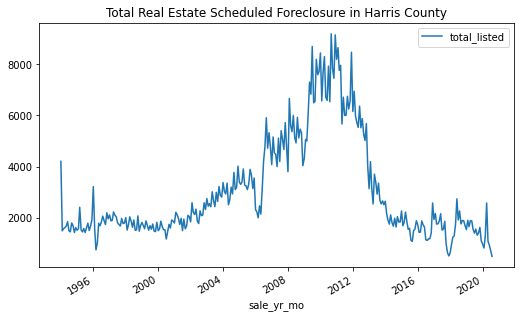

In [58]:
df2.index = pd.to_datetime(df2.sale_yr_mo)
df2.plot(y='total_listed', figsize=(8.5, 5))
plt.title('Total Real Estate Scheduled Foreclosure in Harris County')
plt.show()

## We do not see any signinficant long-term trend
### However we do some differencing

Text(0.5, 1.0, 'First-order differences of Total Scheduled Foreclosure')

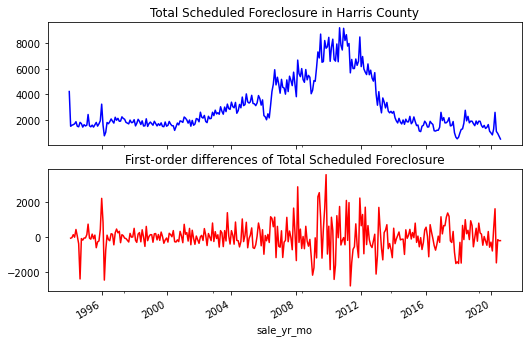

In [59]:
#Let us plot the original time series and first-differences
first_order_diff = df2['total_listed'].diff(1)

fig, ax = plt.subplots(2, sharex=True)
fig.set_size_inches(8.5, 5.5)
df2['total_listed'].plot(ax=ax[0], color='b')
ax[0].set_title('Total Scheduled Foreclosure in Harris County')
first_order_diff.plot(ax=ax[1], color='r')
ax[1].set_title('First-order differences of Total Scheduled Foreclosure')

## Autocorrelation Function (ACF) for different lags and verified by Ljung-Box test

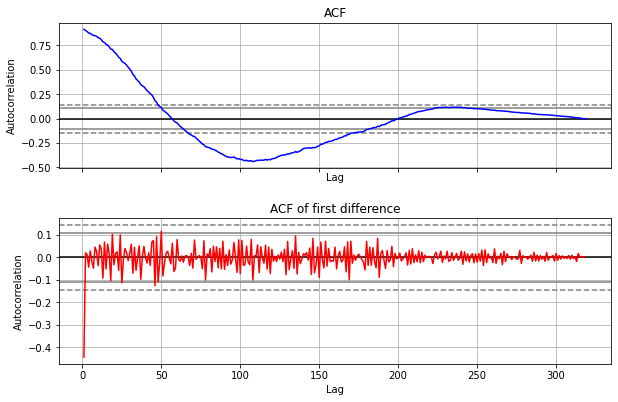

In [60]:
from pandas.plotting import autocorrelation_plot
#Let us plot the ACFs of original time series and first-differences
fig, ax = plt.subplots(2, sharex=True)
fig.set_size_inches(8.5, 5.5)
autocorrelation_plot(df2['total_listed'], color='b', ax=ax[0])
ax[0].set_title('ACF')
autocorrelation_plot(first_order_diff.iloc[1:], color='r', ax=ax[1])
ax[1].set_title('ACF of first difference')
plt.tight_layout(pad=0.4, w_pad=0.5, h_pad=2.0)


In [61]:
## Let us obtain the confidence intervls, Ljung-Box Q-statistics and p-values
acf_forec, confint_forec, qstat_forec, pvalues_forec = stattools.acf(df2['total_listed'],
                                                                 unbiased=True,
                                                                 nlags=20,
                                                                 qstat=True,
                                                                 alpha=0.05)

In [62]:
# Let us check if at confidence level 95% (alpha=0.05) if the null hypothesis is rejected at any of the lags
alpha = 0.05
for l, p_val in enumerate(pvalues_forec):
    if p_val > alpha:
        print('Null hypothesis is accepted at lag = {} for p-val = {}'.format(l, p_val))
    else:
        print('Null hypothesis is rejected at lag = {} for p-val = {}'.format(l, p_val))

Null hypothesis is rejected at lag = 0 for p-val = 5.990205615457179e-61
Null hypothesis is rejected at lag = 1 for p-val = 7.695695566378244e-118
Null hypothesis is rejected at lag = 2 for p-val = 1.2499652074820319e-173
Null hypothesis is rejected at lag = 3 for p-val = 4.1605841210242383e-228
Null hypothesis is rejected at lag = 4 for p-val = 1.4237712009560064e-282
Null hypothesis is rejected at lag = 5 for p-val = 0.0
Null hypothesis is rejected at lag = 6 for p-val = 0.0
Null hypothesis is rejected at lag = 7 for p-val = 0.0
Null hypothesis is rejected at lag = 8 for p-val = 0.0
Null hypothesis is rejected at lag = 9 for p-val = 0.0
Null hypothesis is rejected at lag = 10 for p-val = 0.0
Null hypothesis is rejected at lag = 11 for p-val = 0.0
Null hypothesis is rejected at lag = 12 for p-val = 0.0
Null hypothesis is rejected at lag = 13 for p-val = 0.0
Null hypothesis is rejected at lag = 14 for p-val = 0.0
Null hypothesis is rejected at lag = 15 for p-val = 0.0
Null hypothesis i

### For these p<=.05 we can conclude that data does not have unique roots and time series is Stationary

### If p-value < 0.051: We can reject the null hypothesis assuming a 5% chance of making a mistake. So we can assume that our values are showing dependence on each other.
### If p-value > 0.051: We don't have enough statistical evidence to reject the null hypothesis. So you can not assume that our values are dependent. This could mean that our values are dependent anyway or it can mean that our values are independent. But we are not proving any specific possibility, what our test actually said is that we can not assert the dependence of the values, neither can we assert the independence of the values.

# Which of AR, MA or ARMA should we use?

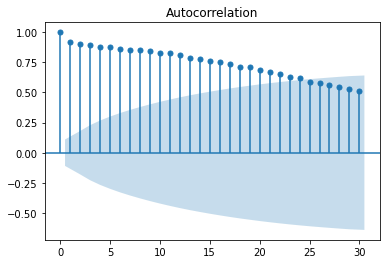

In [63]:
from statsmodels.graphics.tsaplots import plot_acf
y = df2.total_listed
plot_acf(y, lags=30)
fig.set_size_inches(8.5, 5.5)
plt.show()

### Try Partial Autocorrelation Function (PACF), which takes the correlation of time series with a lagged version of itself. Each bar represents the correlation with another lag. So the PACF at 1 is the correlation of initial series with itself, lagged by 1. Hence, for these kinds of plots, 0 will always return 1, because the time series perfectly correlates with itself.

Text(0.5, 1.0, 'Yr Foreclosure Harris County, PACF')

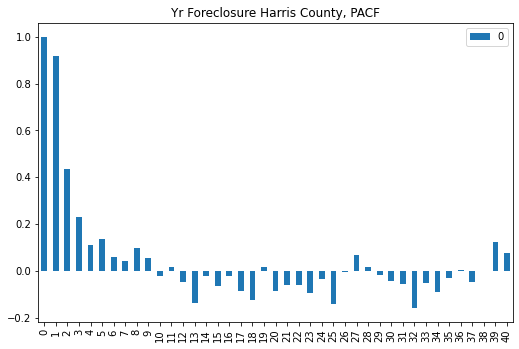

In [64]:
from statsmodels.tsa.stattools import pacf
x_acf = pd.DataFrame(pacf(df2.total_listed))
x_acf.plot(kind='bar', figsize=(8.5, 5.5))
plt.title("Yr Foreclosure Harris County, PACF")

## Try Autoregressive Integrated Moving Average (ARMA), allowing us to add two additional kinds of terms — autoregressions and moving averages — to our specifications. Both autoregressive and moving-average models generally apply to stationary processes. 

### We are building a series of models to evaluate, and each will have slightly different parameters for the ARIMA. 
### Note that the parameters are passed in (p, d, q) order, corresponding to the AR, I, and MA portions, respectively.
### The AR is the past values, I is the level of differencing, and MA is adjusting to past errors.

In [65]:
# To illustrate the idea of moving average we compute yearly moving average taking
# a window of 12 months.
df2['total_listed_moving_avg'] = df2['total_listed'].rolling(12).mean()

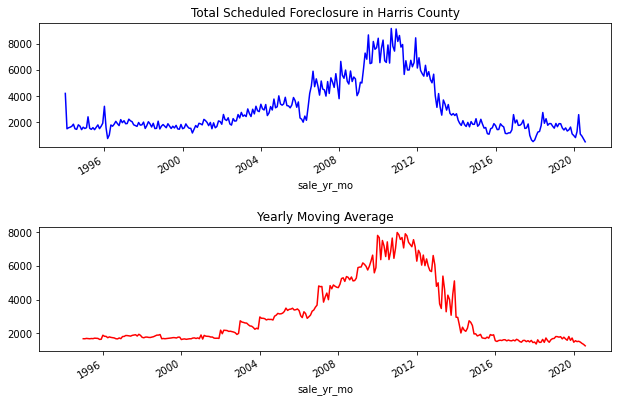

In [66]:
fig = plt.figure(figsize=(8.5, 5.5))
ax = fig.add_subplot(2,1,1)
df2['total_listed'].plot(ax=ax, color='b')
ax.set_title('Total Scheduled Foreclosure in Harris County')
ax = fig.add_subplot(2,1,2)
df2['total_listed_moving_avg'].plot(ax=ax, color='r')
ax.set_title('Yearly Moving Average')
plt.tight_layout(pad=0.4, w_pad=0.5, h_pad=2.0)

In [67]:
#Calculate the moving averages using 'rolling' and 'mean' functions
MA2 = df2['total_listed'].rolling(window=12).mean()
TwoXMA2 = MA2.rolling(window=2).mean()

MA4 = df2['total_listed'].rolling(window=24).mean()
TwoXMA4 = MA4.rolling(window=2).mean()

MA3 = df2['total_listed'].rolling(window=36).mean()
ThreeXMA3 = MA3.rolling(window=3).mean()

In [68]:
#Let's remove NaN from the above variables
MA2 = MA2[~pd.isnull(MA2)]
TwoXMA2 = TwoXMA2[~pd.isnull(TwoXMA2)]

MA4 = MA4[~pd.isnull(MA4)]
TwoXMA4 = TwoXMA4[~pd.isnull(TwoXMA4)]

MA3 = MA3[~pd.isnull(MA3)]
ThreeXMA3 = TwoXMA4[~pd.isnull(ThreeXMA3)]

Text(0.5, 1.0, '36 months MA')

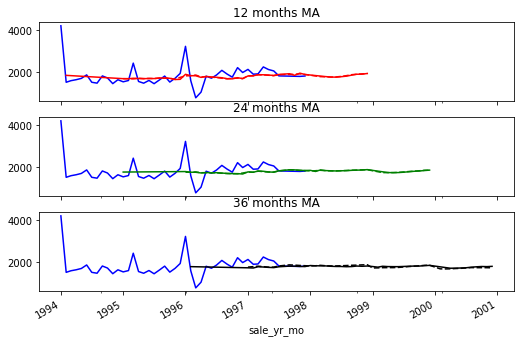

In [69]:

f, axarr = plt.subplots(3, sharex=True)
f.set_size_inches(8.5, 5.5)

df2['total_listed'].iloc[:45].plot(color='b', linestyle = '-', ax=axarr[0])
MA2.iloc[:45].plot(color='r', linestyle = '-', ax=axarr[0])
TwoXMA2.iloc[:45].plot(color='r', linestyle = '--', ax=axarr[0])
axarr[0].set_title('12 months MA')

df2['total_listed'].iloc[:45].plot(color='b', linestyle = '-', ax=axarr[1])
MA4.iloc[:45].plot(color='g', linestyle = '-', ax=axarr[1])
TwoXMA4.iloc[:45].plot(color='g', linestyle = '--', ax=axarr[1])
axarr[1].set_title('24 months MA')

df2['total_listed'].iloc[:45].plot(color='b', linestyle = '-', ax=axarr[2])
MA3.iloc[:45].plot(color='k', linestyle = '-', ax=axarr[2])
ThreeXMA3.iloc[:45].plot(color='k', linestyle = '--', ax=axarr[2])
axarr[2].set_title('36 months MA')

In [70]:
# #Define the time-series evaluation function as follows:
# def timeseries_evaluation_metrics_func(y_true, y_pred):
#     def mean_absolute_percentage_error(y_true, y_pred):
#         y_true, y_pred = np.array(y_true), np.array(y_pred)
#         return np.mean(np.abs((y_true - y_pred) / y_true)) * 100
#     print('Evaluation metric results:-')
#     print(f'MSE is : {metrics.mean_squared_error(y_true, y_pred)}')
#     print(f'MSE is : {metrics.mean_absolute_error(y_true, y_pred)}')
#     print(f'RMSE is : {np.sqrt(metrics.mean_squared_error(y_true, y_pred))}')
#     print(f'MAPE is : {mean_absolute_percentage_error(y_true, y_pred)}')
#     print(f'R2 is : {metrics.r2_score(y_true, y_pred)}',end='\n\n')

## Building ARIMA models

### Here we build a series of models to evaluate, and each will have slightly different parameters for the ARIMA. Note that the parameters are passed in (p, d, q) order, corresponding to the AR, I, and MA portions, respectively. The AR is the past values, I is the level of differencing, and MA is adjusting to past errors.

In [71]:
from statsmodels.tsa.arima_model import ARIMA

In [72]:
model1 = ARIMA(df2.total_listed, order=(20,0,1))
model1_fit = model1.fit()
print(model1_fit.summary())
print('Residuals Description')
#print(model1_fit.resid.describe())

C:\Users\00233270\Anaconda3\envs\prv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
C:\Users\00233270\Anaconda3\envs\prv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:585: ValueWarning: A date index has been provided, but it is not monotonic and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it is not'
                              ARMA Model Results                              
Dep. Variable:           total_listed   No. Observations:                  319
Model:                    ARMA(20, 1)   Log Likelihood               -2524.739
Method:                       css-mle   S.D. of innovations            658.538
Date:                Sun, 20 Dec 2020   AIC                           5095.477
Time:                        11:33

In [73]:
model2 = ARIMA(df2.total_listed, order=(25,0,2))
model2_fit = model2.fit()
print(model1_fit.summary())
print('Residuals Description')
#print(model1_fit.resid.describe())

C:\Users\00233270\Anaconda3\envs\prv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
C:\Users\00233270\Anaconda3\envs\prv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:585: ValueWarning: A date index has been provided, but it is not monotonic and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it is not'
                              ARMA Model Results                              
Dep. Variable:           total_listed   No. Observations:                  319
Model:                    ARMA(20, 1)   Log Likelihood               -2524.739
Method:                       css-mle   S.D. of innovations            658.538
Date:                Sun, 20 Dec 2020   AIC                           5095.477
Time:                        11:39

In [74]:
model3 = ARIMA(df2.total_listed, order=(25,0,1))
model3_fit = model3.fit()
print(model3_fit.summary())
print('Residuals Description')
#print(model3_fit.resid.describe())

C:\Users\00233270\Anaconda3\envs\prv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
C:\Users\00233270\Anaconda3\envs\prv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:585: ValueWarning: A date index has been provided, but it is not monotonic and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it is not'
                              ARMA Model Results                              
Dep. Variable:           total_listed   No. Observations:                  319
Model:                    ARMA(25, 1)   Log Likelihood               -2522.324
Method:                       css-mle   S.D. of innovations            653.159
Date:                Sun, 20 Dec 2020   AIC                           5100.647
Time:                        11:44

In [75]:
from statsmodels.tsa.arima_model import ARIMA
model4 = ARIMA(df2.total_listed, order=(20,1,1))
model4_fit = model4.fit(disp=0)
print(model4_fit.summary())
print('Residuals Description')
print(model4_fit.resid.describe())

C:\Users\00233270\Anaconda3\envs\prv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
C:\Users\00233270\Anaconda3\envs\prv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:585: ValueWarning: A date index has been provided, but it is not monotonic and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it is not'
C:\Users\00233270\Anaconda3\envs\prv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
C:\Users\00233270\Anaconda3\envs\prv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:585: ValueWarning: A date index has been pr

In [78]:
from statsmodels.tsa.arima_model import ARIMA
model5 = ARIMA(df2.total_listed, order=(25,1,1))
model5_fit = model5.fit(disp=0)
print(model5_fit.summary())
print('Residuals Description')
print(model5_fit.resid.describe())

C:\Users\00233270\Anaconda3\envs\prv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
C:\Users\00233270\Anaconda3\envs\prv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:585: ValueWarning: A date index has been provided, but it is not monotonic and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it is not'
C:\Users\00233270\Anaconda3\envs\prv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
C:\Users\00233270\Anaconda3\envs\prv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:585: ValueWarning: A date index has been pr

## How do these models comapre to each other

### One of the easiest ways to compare time series models is with something called the Akaike information criterion (AIC). The AIC is a measure of the degree of information contained in the model. Once you've identified the model with the lowest AIC, you'll compare that model to other models using the probability of information loss. You can find the probability that another model minimizes information loss using the following calculation:

𝑒𝑥𝑝((𝐴𝐼𝐶𝑚𝑖𝑛−𝐴𝐼𝐶𝑥)/2)


In [79]:
aic_lst = [model1_fit.aic, model2_fit.aic, model3_fit.aic, model4_fit.aic, model5_fit.aic]
Min_aic = min(aic_lst)

In [82]:
aic_lst

[5095.477369260883,
 5101.142073206657,
 5100.647462577597,
 5082.93642304867,
 5086.716371670778]

In [80]:
# Best model = Min AIC
min(aic_lst)

5082.93642304867

In [81]:
# Check other AIC compared to best one
for i in aic_lst:
    print(math.exp((Min_aic-i)/2))

0.0018913335700467553
0.00011135078894730334
0.00014259248311333507
1.0
0.15107568976173197


## Conclusion
ARIMA(20,1,1) performs best compared to other models. This also makes sense given the decay patterns we observed from ACF and PACF graphs. 